# VAE

Let's first review variational autoencoder from scratch.

In [3]:
import sys
print(sys.executable)

/home/calvinhuang/snap/snapd-desktop-integration/83/Desktop/media-toc/myenv/bin/python


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

ModuleNotFoundError: No module named 'matplotlib'

## Data

In [6]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform)

Files already downloaded and verified


In [7]:
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_size, valid_size])

print(train_size, valid_size)

40000 10000


In [8]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [11]:
for batch in train_loader:
    print(batch[0].shape)
    print(batch[1].shape)
    break

torch.Size([32, 3, 32, 32])
torch.Size([32])


In [33]:
def visualize_cifar10_samples(tensor, n_cols=9):
    """
    Visualizes CIFAR10 samples.

    Args:
    - tensor (torch.Tensor): Tensor of shape (num_samples, channels, width, height).
    """
    images = tensor.numpy()
    
    # Calculate the number of rows and columns needed for displaying all images
    n_samples = images.shape[0]
    n_rows = np.ceil(n_samples / n_cols).astype(int)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2*n_cols, 2*n_rows))

    for ax, img in zip(axes.ravel(), images):
        # Transpose the image from (C, W, H) to (W, H, C) for visualization
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.axis('off')  # Turn off axis numbers and ticks

    # In case there are less images than subplots, turn off the remaining subplots
    for ax in axes.ravel()[n_samples:]:
        ax.axis('off')

    plt.show()

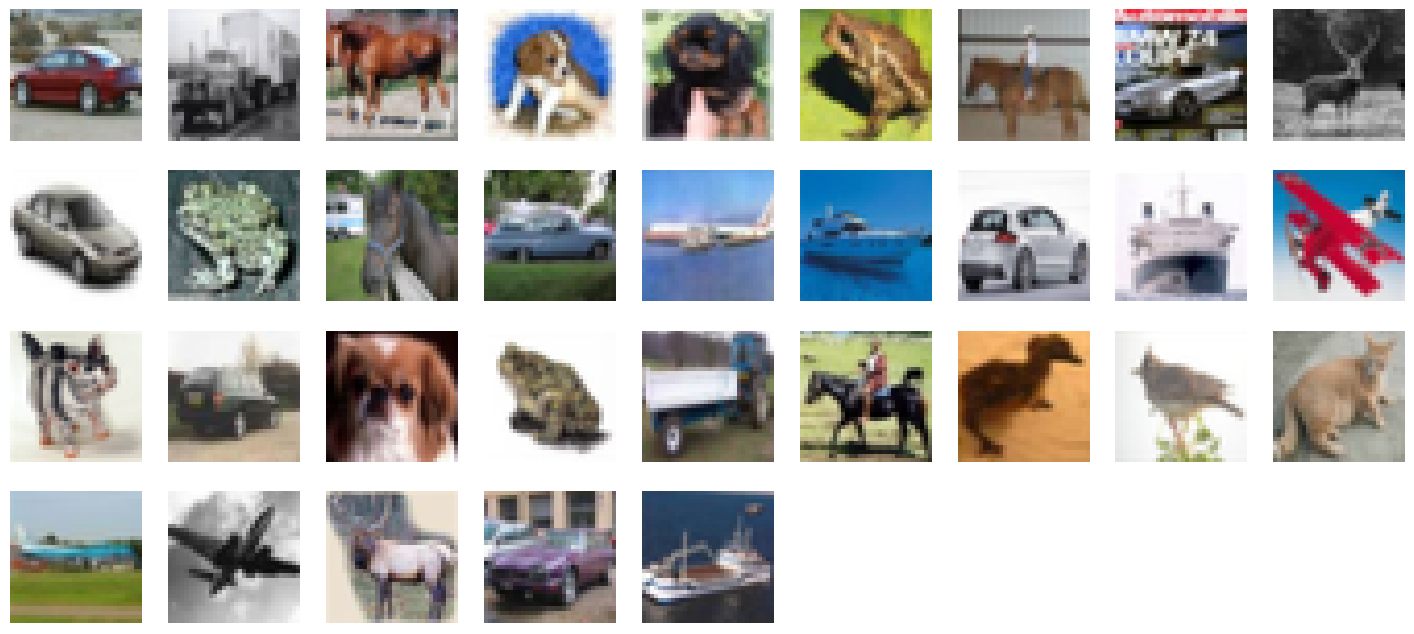

In [34]:
visualize_cifar10_samples(batch[0])

## Model Architecture

In [46]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # Input: (3, 32, 32), Output: (16, 32, 32) | 3-color channels to 16 feature maps
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # Input: (16, 32, 32), Output: (16, 16, 16) | Downsampling using max pooling

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # Input: (16, 16, 16), Output: (32, 16, 16)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # Input: (32, 16, 16), Output: (32, 8, 8)

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Input: (32, 8, 8), Output: (64, 8, 8)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # Input: (64, 8, 8), Output: (64, 4, 4)

            nn.Flatten(),  # Input: (64, 4, 4), Output: 1024 | Flattening spatial data for fully connected layers
            nn.Linear(64*4*4, 256),  # Input: 1024, Output: 256
            nn.ReLU(),
            nn.Linear(256, latent_dim*2)  # Output both mean and log variance
        )
    
    def forward(self, x):
        # The encoder's job is to compress the image into a lower-dimensional latent space.
        # This latent space is represented as a probability distribution described by mean and variance.
        # We use convolutional layers since they can capture the spatial hierarchies present in images.
        # The forward pass for the encoder pushes input data through the network and outputs the mean and log variance.
        return self.layers(x)

In [47]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(latent_dim, 256),  # Input: latent_dim, Output: 256
            nn.ReLU(),
            nn.Linear(256, 64*4*4),  # Input: 256, Output: 1024
            nn.ReLU(),

            nn.Unflatten(1, (64, 4, 4)),  # Input: 1024, Output: (64, 4, 4) | Converting flattened data back to spatial form

            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),  # Input: (64, 4, 4), Output: (32, 8, 8) | Upsampling
            nn.ReLU(),

            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),  # Input: (32, 8, 8), Output: (16, 16, 16)
            nn.ReLU(),

            nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2),  # Input: (16, 16, 16), Output: (3, 32, 32)
            nn.Sigmoid()  # Ensures output is in [0, 1]
        )

    def forward(self, x):
        # The decoder's job is to reconstruct the original image from the latent space representation.
        # It uses transposed convolutions which can upsample the spatial dimensions.
        # The forward pass for the decoder takes in the latent space representation and tries to recreate the original image.
        return self.layers(x)

In [48]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        # VAE's forward method first encodes the input image into the latent space using the encoder.
        # Then, it samples from this space using the reparameterization trick.
        # Finally, it decodes the sampled representation using the decoder to produce the reconstructed image.
        h = self.encoder(x) # h: [batch_size, latent_dim*2]
        mu, logvar = h.split(h.size(1)//2, dim=1) # mu: [batch_size, latent_dim] logvar: [batch_size, latent_dim]
        z = self.reparameterize(mu, logvar) # z: [batch_size, latent_dim]
        return self.decoder(z), mu, logvar # decoder(z): [batch_size, 3, 32, 32]

Test the arch.

In [55]:
latent_dim = 32
encoder = Encoder(latent_dim)
decoder = Decoder(latent_dim)
model = VAE(latent_dim)

In [50]:
x = batch[0][0].unsqueeze(0) # adds new dim at beginning
print(x.shape)

torch.Size([1, 3, 32, 32])


In [51]:
with torch.no_grad():
    encoded = encoder(x)
print("Shape after encoding:", encoded.shape)

Shape after encoding: torch.Size([1, 64])


In [52]:
z = encoded[:, :latent_dim]
print("Mean:", z.shape)

Mean: torch.Size([1, 32])


In [53]:
with torch.no_grad():
    decoded = decoder(z)
print("Shape after decoding:", decoded.shape)

Shape after decoding: torch.Size([1, 3, 32, 32])


In [57]:
with torch.no_grad():
    output = model(x)
print("Shape of VAE output:", output[0].shape)

Shape of VAE output: torch.Size([1, 3, 32, 32])


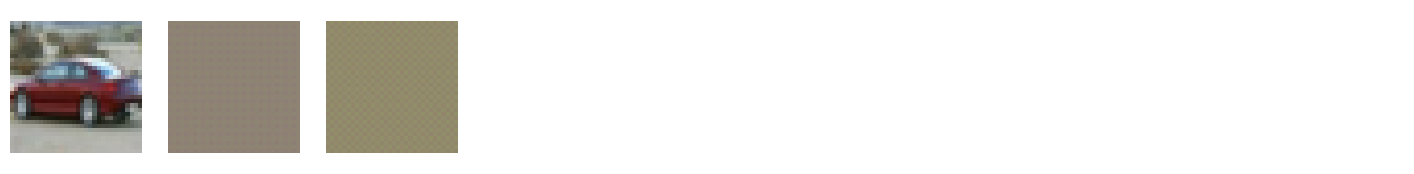

In [58]:
visualize_cifar10_samples(torch.cat((x, decoded, output[0]), dim=0))

## Training

In [84]:
latent_dim = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VAE(latent_dim)
model.to(device)

# Hyperparameters
learning_rate = 1e-3
epochs = 100
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss(reduction='sum')
model_save_path = './models/vae_cifar10.pt'

def loss_function(recon_x, x, mu, logvar):
    BCE = criterion(recon_x, x)                # BCE measures how well the reconstructed samples match the originals
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  # Measures divergence from a unit Gaussian
    return BCE + KLD                           # Summing both to get the final VAE loss

In [82]:
best_valid_loss = float('inf')
pbar = tqdm(range(epochs), ncols=100)

for epoch in pbar:                                            # Tracking progress over epochs
    model.train()                                             # Setting model to training mode
    train_loss = 0                                           
    for batch in train_loader:                                # Looping over batches of data
        inputs = batch[0].to(device)                          # Sending data to GPU/CPU
        optimizer.zero_grad()                                 # Zeroing gradients, crucial for correct backpropagation
        
        recon_batch, mu, logvar = model(inputs)               # Forward pass: Get reconstructions and latent variables
        loss = loss_function(recon_batch, inputs, mu, logvar) # Compute the VAE loss
        loss.backward()                                       # Backward pass: Compute gradients
        train_loss += loss.item()                             # Aggregate loss for logging
        optimizer.step()                                      # Update the model weights using computed gradients

    model.eval()
    valid_loss = 0
    with torch.no_grad():                                     # No gradient computation in validation
        for batch in valid_loader:
            inputs = batch[0].to(device)
            recon, mu, logvar = model(inputs)
            valid_loss += loss_function(recon, inputs, mu, logvar).item()

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), './models/vae_cifar10.pt')
    
    pbar.set_postfix({"Train Loss": train_loss / len(train_loader), "Valid Loss": valid_loss / len(valid_loader)})

100%|█████████████████████| 100/100 [12:54<00:00,  7.75s/it, Train Loss=5.84e+4, Valid Loss=5.85e+4]


## Inference

In [87]:
best_checkpoint = torch.load(model_save_path, map_location=torch.device('cpu'))
model.load_state_dict(best_checkpoint)
model.to(device)
print(device)

cuda


Test reconstruction.

In [88]:
for batch in test_loader:
    with torch.no_grad():
        inputs = batch[0].to(device)
        reconstructed = model(inputs)
    break

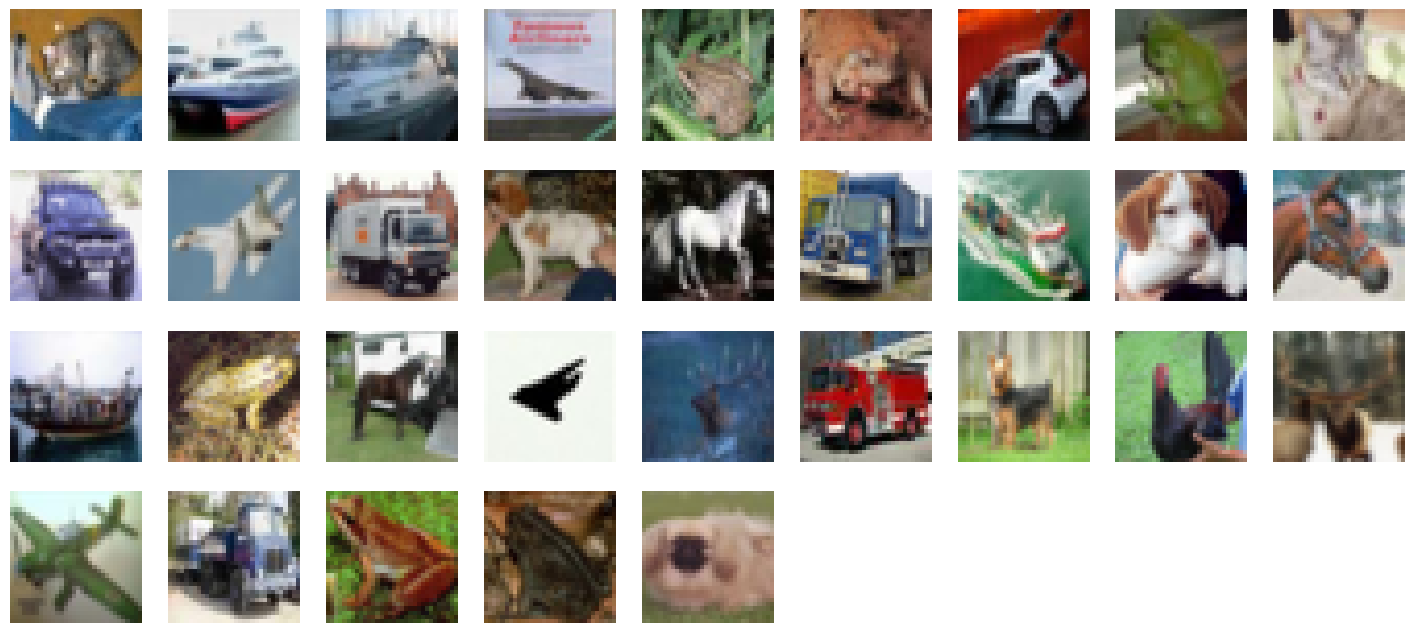

In [89]:
visualize_cifar10_samples(inputs.cpu())

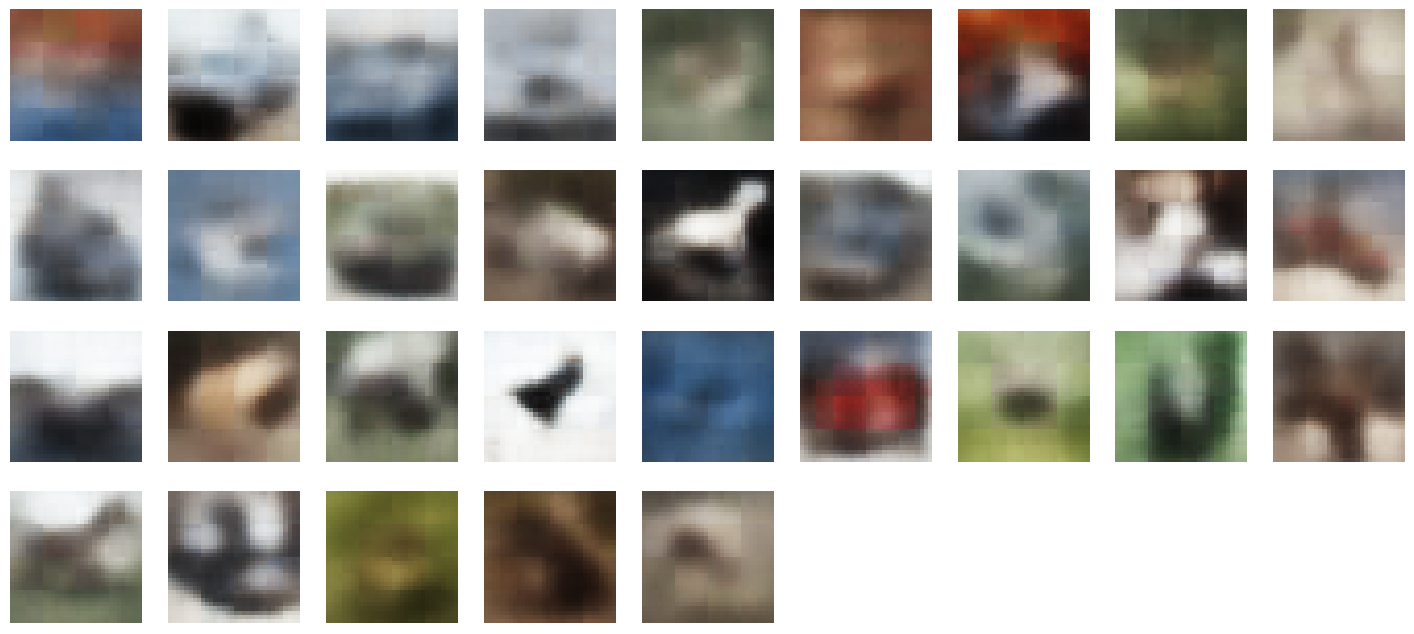

In [90]:
visualize_cifar10_samples(reconstructed[0].cpu())

Using only decoder.

In [91]:
def generate_random_cifar10(n_samples, model, latent_dim):
    model.eval()

    # Sample from a standard Gaussian (since VAE's latent space is designed to mimic this distribution)
    random_latent_vectors = torch.randn(n_samples, latent_dim).to(device)
    
    with torch.no_grad():
        generated_images = model.decoder(random_latent_vectors)
    return generated_images.cpu()

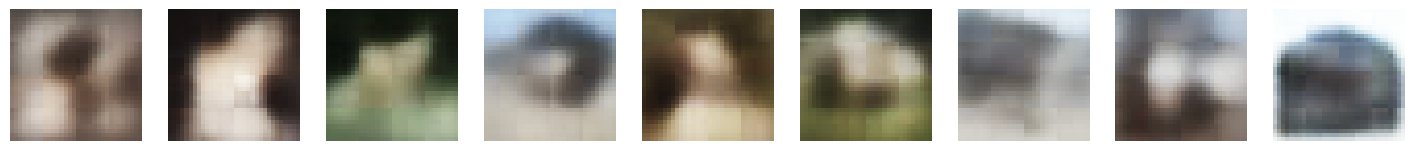

In [92]:
visualize_cifar10_samples(generate_random_cifar10(9, model, latent_dim))

# EBM with MCMC

Imports.

In [2]:
import torch as t
import torch.nn as nn
import torchvision as tv, torchvision.transforms as tr

# for reproducible results
seed = 1
t.manual_seed(seed)
if t.cuda.is_available():
    t.cuda.manual_seed_all(seed)

Define hyperparams.

In [3]:
# Set device for computation
device = t.device('cuda' if t.cuda.is_available() else 'cpu')

# Constants
sigma = 3e-2     # decrease until training is unstable
im_sz = 32       # Image size
m = 64           # Mini-batch size
K = 100          # Number of steps of MCMC
n_ch = 3         # Number of channels in the image (RGB)
n_f = 64         # Number of features, can be increased until compute is exhausted
l = 0.2          # LeakyReLU parameter

Preprocessing and Data Sampling

In [4]:
# Preprocess images by resizing, converting to tensor and normalizing
preprocess_images = tr.Compose([
    tr.Resize(im_sz),
    tr.ToTensor(),
    tr.Normalize((.5, .5, .5), (.5, .5, .5))
])

# Load the CIFAR-10 dataset and apply preprocessing
data_tensor = t.stack([x[0] for x in tv.datasets.CIFAR10(root='./data', transform=preprocess_images, download=True)]).to(device)

# Function to add Gaussian noise to data
def add_noise_to_data(data, sigma):
    return data + sigma * t.randn_like(data)

# Sample from the preprocessed data distribution and add Gaussian noise
def sample_from_data_distribution():
    random_indices = t.LongTensor(m).random_(0, data_tensor.shape[0])
    return add_noise_to_data(data_tensor[random_indices], sigma).detach()

Files already downloaded and verified


In [5]:
data_tensor.shape

torch.Size([50000, 3, 32, 32])

Energy function architecture.

In [122]:
class EnergyFunction(nn.Module):
    def __init__(self, n_c=n_channels, n_f=n_f, l=0.2):
        super(EnergyFunction, self).__init__()
        
        # Neural network representing the energy function
        self.f = nn.Sequential(
            # Input: (n_channels x 32 x 32)
            nn.Conv2d(n_c, n_f, 3, 1, 1),          # 32x32 -> 32x32 (due to padding of 1)
            nn.LeakyReLU(l),
            
            nn.Conv2d(n_f, n_f * 2, 4, 2, 1),      # 32x32 -> 16x16 (strided conv)
            nn.LeakyReLU(l),
            
            nn.Conv2d(n_f * 2, n_f * 4, 4, 2, 1),  # 16x16 -> 8x8
            nn.LeakyReLU(l),
            
            nn.Conv2d(n_f * 4, n_f * 8, 4, 2, 1),  # 8x8 -> 4x4
            nn.LeakyReLU(l),
            
            nn.Conv2d(n_f * 8, 1, 4, 1, 0)         # 4x4 -> 1x1
        )
        
    def forward(self, x):
        return self.f(x).squeeze()

Sampling using energy function's learned distribution.

In [123]:
energy_func = EnergyFunction().to(device)

# Generate random noise images
def generate_noise_images():
    return t.FloatTensor(m, n_channels, im_sz, im_sz).uniform_(-1, 1).to(device)

# Sample using short-run MCMC from the model's distribution
def sample_from_model(f, K=K):
    samples = t.autograd.Variable(generate_noise_images(), requires_grad=True)  # Create random images with noise and set requires_grad=True for gradient computation
    
    for _ in range(K):
        gradient = t.autograd.grad(energy_func(samples).sum(), [samples], retain_graph=True)[0]  # Compute gradient of summed energy over all samples
        samples.data += gradient + 1e-2 * t.randn_like(samples)                                  # Move towards gradient and add additional noise
        
    return samples.detach()  # Detach the tensor from the computation graph

Training

In [124]:
# Helper function to plot images
def plot_images(path, images):
    tv.utils.save_image(t.clamp(images, -1., 1.), path, normalize=True, nrow=int(t.sqrt(t.Tensor([m]))))

# Optimizer setup
optimizer = t.optim.Adam(energy_func.parameters(), lr=1e-4, betas=[.9, .999])

# Training loop
num_iterations = 10000  # Example
for i in range(num_iterations):
    real_samples = sample_from_data_distribution()
    model_samples = sample_from_model(energy_func)
    
    # Compute loss as the difference in energy values of real and model samples
    loss = energy_func(real_samples).mean() - energy_func(model_samples).mean()

    # Backpropagation and optimization
    optimizer.zero_grad()
    (-loss).backward() # MLE, min -loss = max loss
    optimizer.step()

    # Logging and visualization
    if i % 100 == 0:
        print(f'Iteration {i} | Real Sample Energy: {energy_func(real_samples).mean()} | Model Sample Energy: {energy_func(model_samples).mean()}')
        plot_images(f'./ebm_images/output_images_{i}.png', model_samples)

Iteration 0 | Real Sample Energy: 0.01683351770043373 | Model Sample Energy: -0.011464422568678856
Iteration 100 | Real Sample Energy: -1.1192139387130737 | Model Sample Energy: -3.0413942337036133
Iteration 200 | Real Sample Energy: 3.1051204204559326 | Model Sample Energy: 1.430238127708435
Iteration 300 | Real Sample Energy: 5.460487365722656 | Model Sample Energy: 3.916862964630127
Iteration 400 | Real Sample Energy: 4.616377830505371 | Model Sample Energy: 4.556326389312744
Iteration 500 | Real Sample Energy: 6.286043167114258 | Model Sample Energy: 4.674713134765625
Iteration 600 | Real Sample Energy: 6.284090042114258 | Model Sample Energy: 4.98255729675293
Iteration 700 | Real Sample Energy: 6.161309242248535 | Model Sample Energy: 5.201096534729004
Iteration 800 | Real Sample Energy: 7.01876163482666 | Model Sample Energy: 5.09476375579834
Iteration 900 | Real Sample Energy: 6.554436683654785 | Model Sample Energy: 7.493010997772217
Iteration 1000 | Real Sample Energy: 6.86322